In [326]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

### Data cleaning

In [327]:
#read in each dataframe and add type column
whey = pd.read_csv('wheyprotein.csv', header=None)
whey['type']='Whey'
plantbased = pd.read_csv('plantbasedprotein.csv', header=None)
plantbased['type']='Plant Based'
natural = pd.read_csv('naturalprotein.csv', header=None)
natural['type'] = 'Natural'
other = pd.read_csv('otherprotein.csv', header=None)
other['type']  = 'Other'
casein = pd.read_csv('caseinprotein.csv', header=None)
casein['type'] = 'Casein'

In [328]:
#concat all dfs together
df_list = [whey,plantbased,natural,casein,other]
proteins = pd.concat(df_list)
proteins = proteins.reset_index(drop=True)
proteins.columns = ['product_name','item_number','listed_price','price_per_serving','brand','ingredients','rating','number_reviews','recommended_yes','recommended_no','blank','form','calories','type']

In [329]:
#Clean big data frame - fix strings and change type to float
proteins= proteins.drop(columns=['blank', 'form','calories','ingredients'])
proteins['listed_price'] = proteins['listed_price'].str.replace('$', '').astype(float)
proteins['price_per_serving'] = proteins['price_per_serving'].str.replace('/serving', '').str.replace('$', '').str.replace(r'[()]',"").astype(float)

In [330]:
#Switch recommended values to fix errors
proteins['recommended_yes'],proteins['recommended_no']=np.where(proteins['recommended_yes'].str.contains('No'),(proteins['recommended_yes'],proteins['recommended_no']),(proteins['recommended_no'],proteins['recommended_yes']))
proteins['recommended_yes'],proteins['recommended_no']=np.where(proteins['recommended_no'].str.contains('Yes'),(proteins['recommended_no'],proteins['recommended_yes']),(proteins['recommended_yes'],proteins['recommended_no']))

In [331]:
# More string cleaning
proteins['recommended_yes']=proteins['recommended_yes'].str.replace('Yes','').str.replace(r'[()]',"").astype(float)
proteins['recommended_no']=proteins['recommended_no'].str.replace('No','').str.replace(r'[()]',"").astype(float)
proteins['number_reviews']= proteins['number_reviews'].str.replace('Reviews','').str.replace('Review','').str.replace(',','').astype(float)
proteins['item_number']= proteins['item_number'].str.replace('Item # : ','')
proteins['rating']=proteins['rating'].str.replace(' / 5.0','').astype(float)

In [332]:
#Find how many missing values in each column
np.sum(proteins.isnull())

product_name           0
item_number            0
listed_price           0
price_per_serving      2
brand                  0
rating               362
number_reviews       362
recommended_yes      380
recommended_no       511
type                   0
dtype: int64

In [333]:
proteins.describe()

,listed_price,price_per_serving,rating,number_reviews,recommended_yes,recommended_no
count,690.000000,688.000000,328.000000,328.000000,310.000000,179.000000
mean,37.986826,1.646599,4.314024,24.646341,9.200000,3.351955
std,14.439446,0.777399,0.711495,86.543531,10.983306,3.342631
min,9.980000,0.090000,1.000000,1.000000,1.000000,1.000000
25%,29.990000,1.110000,4.000000,3.000000,2.000000,1.000000
50%,36.700000,1.450000,4.500000,8.000000,5.500000,2.000000
75%,44.990000,1.990000,4.900000,19.250000,11.000000,4.000000
max,129.990000,5.390000,5.000000,1278.000000,75.000000,17.000000


In [542]:
#25% of number of reviews was 3
#filtered proteins data to exclude products with less than 3 reviews
proteins_rev = proteins[proteins['number_reviews'] > 3.0]
proteins_rev = proteins_rev.reset_index(drop=True)
proteins_rev.describe()

,listed_price,price_per_serving,rating,number_reviews,recommended_yes,recommended_no
count,242.000000,242.000000,242.000000,242.000000,240.000000,165.000000
mean,38.765041,1.510868,4.276033,32.772727,11.441667,3.545455
std,14.836071,0.705938,0.552779,99.545659,11.553619,3.411699
min,15.990000,0.430000,2.600000,4.000000,1.000000,1.000000
25%,29.990000,1.040000,3.900000,7.000000,4.000000,1.000000
50%,37.490000,1.290000,4.400000,12.000000,7.500000,2.000000
75%,45.865000,1.832500,4.800000,28.750000,12.000000,4.000000
max,129.990000,4.410000,5.000000,1278.000000,75.000000,17.000000


In [543]:
np.sum(proteins_rev.isnull())

product_name          0
item_number           0
listed_price          0
price_per_serving     0
brand                 0
rating                0
number_reviews        0
recommended_yes       2
recommended_no       77
type                  0
dtype: int64

In [544]:
# Will still use unfiltered protein df for price analysis

In [545]:
#export files to csv
proteins.to_csv('proteins.csv')
proteins_rev.to_csv('filteredproteins.csv')

## Analysis

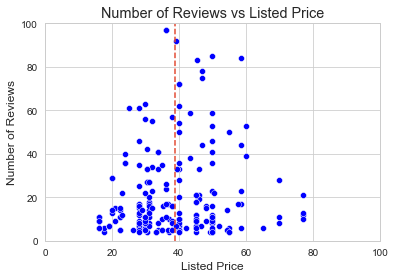

In [389]:
#scatter plot to analyze relationship between price and number of reviews
sns.set_style("whitegrid");
sns.scatterplot(x= "listed_price", y= "number_reviews", data=proteins_rev, color='blue')
plt.ylim(0,100)
plt.xlim(0,100)
plt.xlabel('Listed Price')
plt.ylabel('Number of Reviews')
plt.title("Number of Reviews vs Listed Price")
plt.axvline(38.765041, linestyle= '--')

In [459]:
proteins_rev.groupby('type').agg({'number_reviews':['mean','median']})

number_reviews       
                      mean median
type                             
Casein           31.375000   21.5
Natural          59.463415   16.0
Other            14.782609    8.0
Plant Based      38.684211   19.5
Whey             32.000000   13.0

In [391]:
correlations = proteins_rev.groupby('type').corr(method='pearson')['listed_price'].sort_values(ascending=False)
correlations[5:15]

type                          
Casein       rating               0.431303
Natural      price_per_serving    0.424508
Plant Based  price_per_serving    0.400105
Whey         rating               0.344002
Plant Based  recommended_yes      0.253460
             rating               0.245005
Natural      rating               0.209026
Plant Based  number_reviews       0.204129
Other        rating               0.181919
             price_per_serving    0.170981
Name: listed_price, dtype: float64

Text(0, 0.5, 'Listed Price')

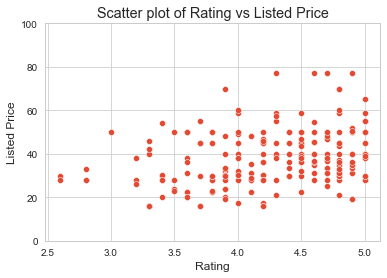

In [360]:
#scatter plot to analyze relationship between price and rating
sns.set_style("whitegrid");
sns.scatterplot(x = "rating", y = "listed_price", data= proteins_rev)
plt.ylim(0,100)
plt.title("Scatter plot of Rating vs Listed Price")
plt.xlabel('Rating')
plt.ylabel('Listed Price')

Text(0, 0.5, 'Listed Price')

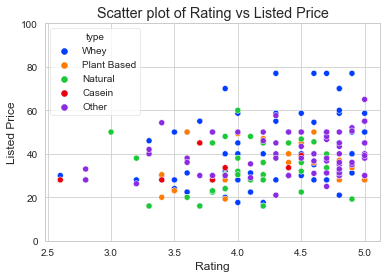

In [364]:
#scatter plot to analyze relationship between price and rating separated by type
sns.set_style("whitegrid");
sns.scatterplot(x = "rating", y = "listed_price", hue='type', data=proteins_rev, palette='bright')
plt.ylim(0,100)
plt.title("Scatter plot of Rating vs Listed Price")
plt.xlabel('Rating')
plt.ylabel('Listed Price')

In [369]:
proteins.groupby('type').agg({'price_per_serving':['mean','median']})

price_per_serving       
                         mean median
type                                
Casein               1.273077   1.29
Natural              1.767682   1.71
Other                1.918136   1.59
Plant Based          1.775039   1.67
Whey                 1.288532   1.21

In [368]:
proteins.groupby('type').agg({'listed_price':['mean','median']})

listed_price       
                    mean median
type                           
Casein         34.897692  34.99
Natural        35.282649  35.99
Other          40.093371  39.19
Plant Based    34.067132  34.99
Whey           40.631416  39.99

Text(0, 0.5, 'Listed Price')

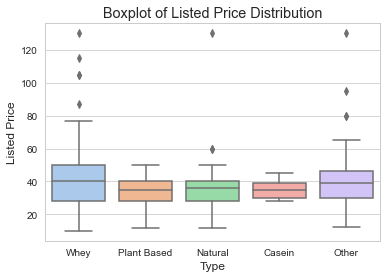

In [372]:
#boxplot of each types distribution of listed prices
sns.boxplot(x='type', y='listed_price', data=proteins, palette='pastel')
plt.title("Boxplot of Listed Price Distribution")
plt.xlabel('Type')
plt.ylabel('Listed Price')

Text(0, 0.5, 'Price Per Serving')

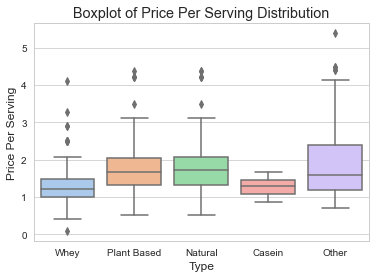

In [373]:
#boxplot of each types distribution of price per serving
sns.boxplot(x='type', y='price_per_serving', data=proteins, palette='pastel')
plt.title("Boxplot of Price Per Serving Distribution")
plt.xlabel('Type')
plt.ylabel('Price Per Serving')

Text(0, 0.5, 'Average Rating')

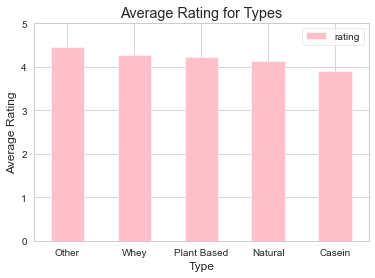

In [433]:
#average rating for each type
proteins_avg_rating= proteins_rev.groupby('type').agg({'rating':'mean'})
proteins_avg_rating.sort_values(by = 'rating', ascending = False).plot.bar(color = 'pink')
plt.ylim(0,5)
plt.xticks(rotation=0)
plt.title("Average Rating for Types")
plt.xlabel('Type')
plt.ylabel('Average Rating')

Text(14.772083333333342, 0.5, 'Density')

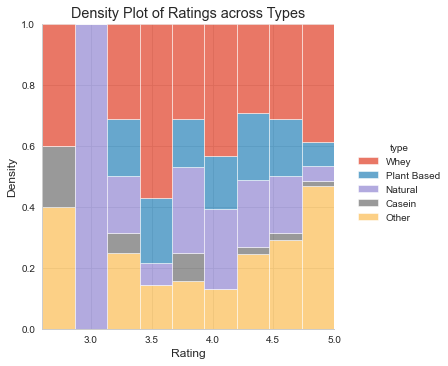

In [435]:
#distribution for ratings of each type
sns.displot(proteins_rev, x='rating', hue='type', kind='hist', multiple="stack")
plt.title('Ratings across Types')
plt.xlabel('Rating')

Text(0, 0.5, 'Recommended Yes')

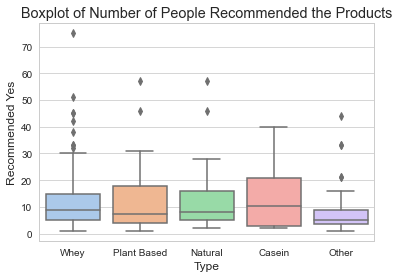

In [449]:
#boxplot to show distribution of how many recommended products
sns.boxplot(x='type', y='recommended_yes', data=proteins_rev, palette='pastel')
plt.title('Boxplot of Number of People Recommended the Products')
plt.xlabel('Type')
plt.ylabel('Recommended Yes')

Text(0, 0.5, 'Recommended No')

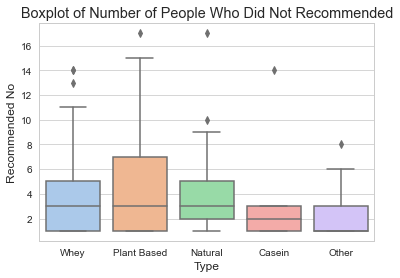

In [460]:
#boxplot to show distribution of how many did not recommended products
sns.boxplot(x='type', y='recommended_no', data=proteins_rev, palette='pastel')
plt.title('Boxplot of Number of People Who Did Not Recommended')
plt.xlabel('Type')
plt.ylabel('Recommended No')


In [ ]:
#Find which brands carry each type of product

Text(0, 0.5, 'Count')

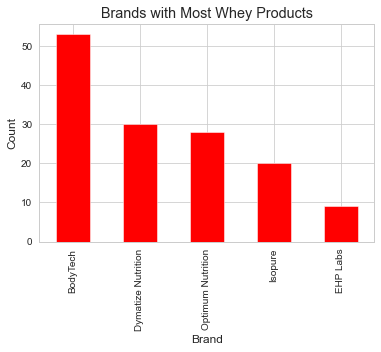

In [496]:
Whey= proteins.loc[(proteins['type'] == 'Whey')]
Whey[['brand','type']].groupby('brand').size().nlargest(5).plot.bar(color = 'red')
plt.title('Brands with Most Whey Products')
plt.xlabel('Brand')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

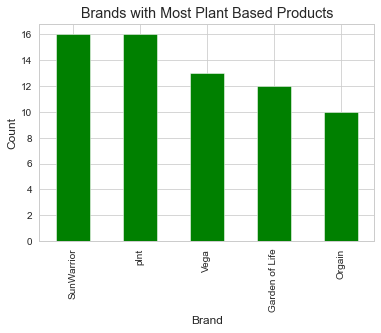

In [497]:
PlantB= proteins.loc[(proteins['type'] == 'Plant Based')]
PlantB[['brand','type']].groupby('brand').size().nlargest(5).plot.bar(color = 'green')
plt.title('Brands with Most Plant Based Products')
plt.xlabel('Brand')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

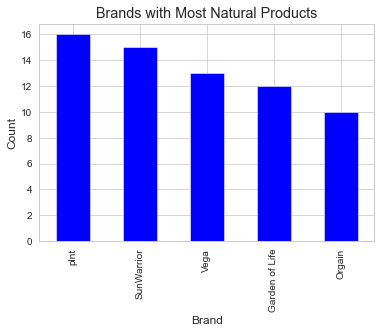

In [498]:
Natural= proteins.loc[(proteins['type'] == 'Natural')]
Natural[['brand','type']].groupby('brand').size().nlargest(5).plot.bar(color = 'blue')
plt.title('Brands with Most Natural Products')
plt.xlabel('Brand')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

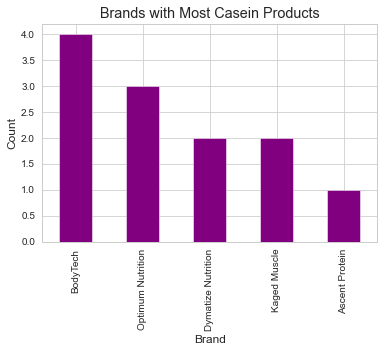

In [500]:
Casein= proteins.loc[(proteins['type'] == 'Casein')]
Casein[['brand','type']].groupby('brand').size().nlargest(5).plot.bar(color = 'purple')
plt.title('Brands with Most Casein Products')
plt.xlabel('Brand')
plt.ylabel('Count')

In [ ]:
#one should cross reference brand offering data with highest rated brands:

Text(0.5, 1.0, 'Top 10 Highest Rated Brand')

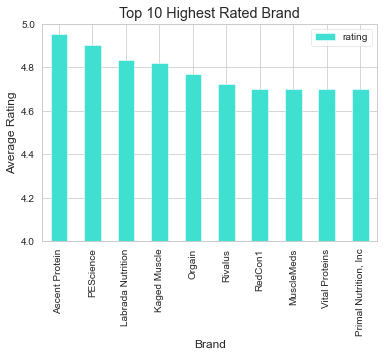

In [529]:
top10_brands= proteins_rev.groupby(['brand']).agg({'rating':'mean'}).sort_values(by='rating', ascending=False).head(10)
top10_brands.plot.bar(color = 'turquoise')
plt.ylim(4,5)
plt.xlabel('Brand')
plt.ylabel('Average Rating')
plt.title('Top 10 Highest Rated Brand')